In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import pandas as pd
from helpers import subsample_train, smooth
from xgboost import XGBClassifier

from automated_scoring.classification import k_fold_predict
from automated_scoring.classification.optimization_utils import evaluate_results
from automated_scoring.classification.visualization import plot_classification_timeline
from automated_scoring.config import cfg
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.io import load_dataset
from automated_scoring.utils import ensure_generator, IterationManager
from automated_scoring.logging import set_logging_level

In [4]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [5]:
dataset_train = load_dataset(
    "mice_train",
    directory="../../datasets/CALMS21/train",
    target="dyad",
    background_category="none",
)
dataset_test = load_dataset(
    "mice_test",
    directory="../../datasets/CALMS21/test",
    target="dyad",
    background_category="none",
)

2025-02-26 21:56:03.904 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
2025-02-26 21:56:04.526 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [6]:
observations = dataset_train.exclude_individuals(["intruder"]).observations

In [24]:
intervals = np.array(observations.set_index("category").loc["attack"].reset_index()[["start", "stop"]])

intervals[:, 1] - intervals[:, 0] + 1

array([152,  51,  62,  38,  12,  52,   9,  17,  16,  25,  41,  11,  49,
        45, 205,  98,  49,  42,  17,  33,  19,   9,  75,   5,  18,   9,
         6,  81,   9,  16,  20,  73,  10,  51,  12,  23,  46,  12,  75,
        17,  18,  15,  33,  17,  33,  28,  17,  96, 165,  99,  15,  10,
        22, 117,  26, 219, 122,  29, 145,  98, 142, 200, 309, 197, 196,
        72,  44,   9,  23, 204,  44,   4, 131, 276,  58, 104, 211,  52,
       125,  19,  53,  48,  33,  36,  33,  78,  35,  73,   1,  20,  67,
        42, 158,  45,  86, 100, 140, 107, 211, 288, 141,  58,  15, 168,
       266, 221,  57,  29,  60,  77,  75,  90,  25,  95,  99,  47,  23,
         6, 137,  68,  37,  32, 136,  22,  59,  32,  11,  58,  58, 416,
        46, 669, 158,  15,  12, 115,  61,  67, 233, 188, 239,  10, 232,
       184,  18, 109,  66,  98,  64,  35,  55, 129, 134, 126,  18,  11,
        20,  55,  43, 107,  59,  62,  87,  37,  18,   5,  11,  43,   7,
        50,  14, 110,  33,  29,  53,  18,  38,  18,  46,  28,  4

In [5]:
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml(
    "config_file.yaml"
)

In [6]:
# this cell is equivalent to smoothing_experiment-mice.py
# 5-fold cross-validation is performed num_iteration (20) times to average out stochasticity
# these iterations can be performed in parallel on a cluster (using mpi4py) as they don't depend on each other


from automated_scoring.classification.optimize import optimize_smoothing


best_parameters = optimize_smoothing(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    XGBClassifier(n_estimators=100),
    smooth,
    smoothing_parameters_grid={"median_filter_window": np.arange(1, 91, 8)},
    remove_overlapping_predictions=False,
    num_iterations=3,
    k=5,
    sampling_func=subsample_train,
    plot_results=False,
    results_path="optimization_results/smoothing",
    log=set_logging_level("info"),
    iteration_manager=IterationManager(random_state=1),
)

print(best_parameters)

2025-02-26 19:52:46.860 [INFO    ] started smoothing optimization
2025-02-26 19:52:46.860 [INFO    ] [iteration: 0] started k-fold cross-validation
2025-02-26 19:52:46.888 [INFO    ] [iteration: 0] [fold: 0/5] started sampling
2025-02-26 19:52:47.503 [SUCCESS ] [iteration: 0] [fold: 0/5] finished sampling in 0.61 seconds
2025-02-26 19:52:47.523 [INFO    ] [iteration: 0] [fold: 0/5] started fitting XGBClassifier
2025-02-26 19:52:56.926 [SUCCESS ] [iteration: 0] [fold: 0/5] finished fitting XGBClassifier in 9.40 seconds
2025-02-26 19:52:56.926 [INFO    ] [iteration: 0] [fold: 0/5] started predicting on dataset
2025-02-26 19:52:57.208 [INFO    ] [iteration: 0] [fold: 0/5] [group: 0/14] [1/1] finished predictions
2025-02-26 19:52:57.209 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] finished predictions
2025-02-26 19:52:57.567 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] [1/1] finished predictions
2025-02-26 19:52:57.567 [INFO    ] [iteration: 0] [fold: 0/5] [group: 2/14] finis

{'attack': {'median_filter_window': 89.0}, 'investigation': {'median_filter_window': 17.0}, 'mount': {'median_filter_window': 89.0}, 'none': {'median_filter_window': 17.0}}


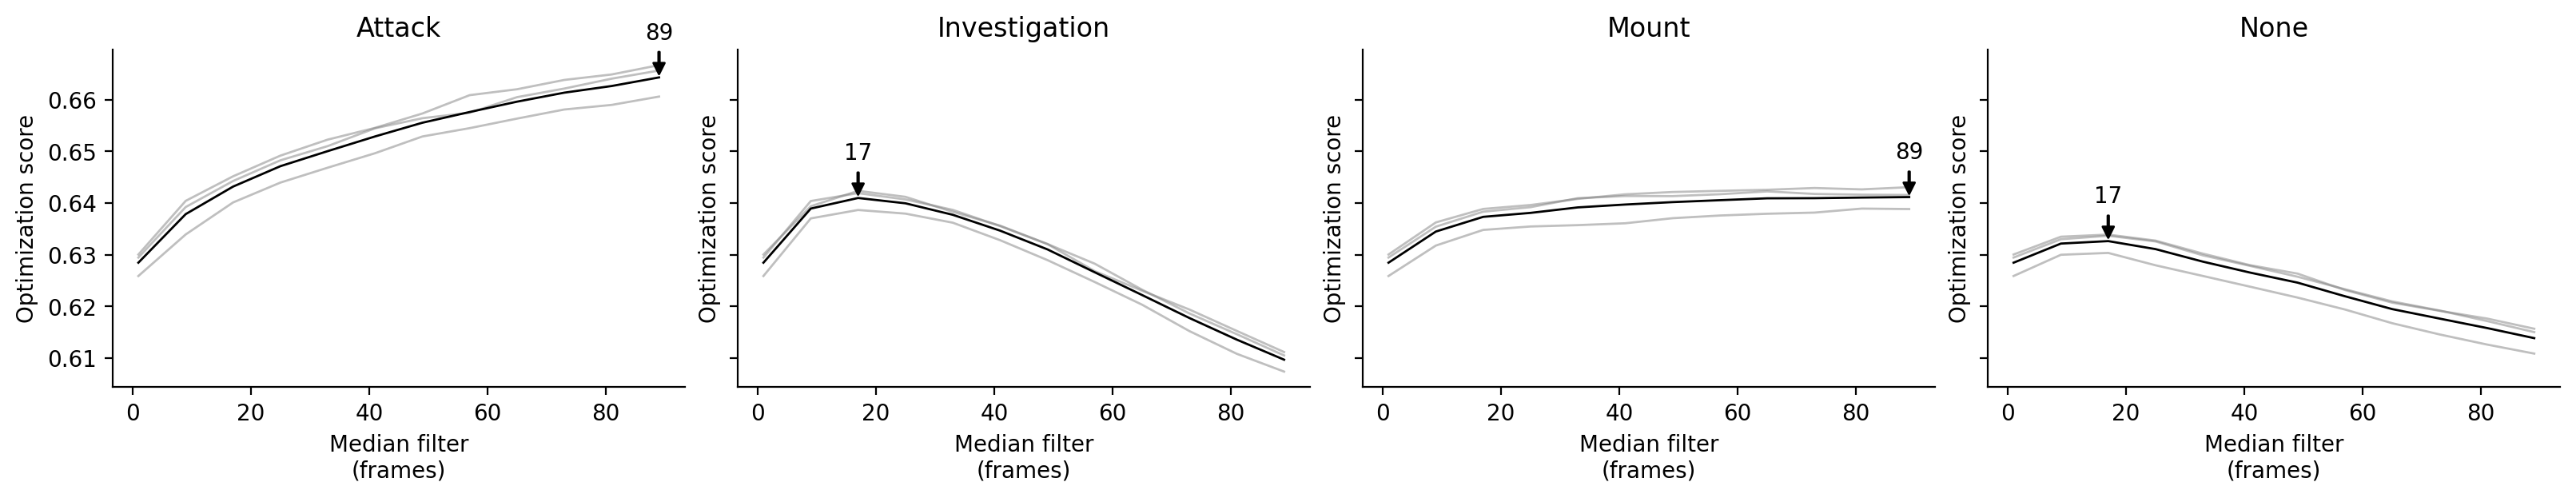

In [7]:
from automated_scoring.classification.optimization_utils import evaluate_results


import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(dataset_train.categories), figsize=(16, 3), layout="constrained", sharex=True, sharey=True)

results = {}

for idx, category in enumerate(dataset_train.categories):
    results[category] = evaluate_results(
        pd.read_csv(f"optimization_results/smoothing/results_smoothing-{category}.csv"),
        parameter_names=["median_filter_window"],
        score_names=["f1_per_timestamp", "f1_per_annotation", "f1_per_prediction"],
        plot_results=True,
        axes=axes[[idx]],
    )
    axes[idx].set_xlabel("Median filter\n(frames)")
    axes[idx].set_ylabel("Optimization score")
    axes[idx].set_title(category.replace("_", " ").capitalize())

print(results)

plt.show()

In [8]:
pd.read_csv(f"optimization_results/smoothing/results_smoothing-attack.csv")

,iteration,median_filter_window,f1_per_timestamp,f1_per_annotation,f1_per_prediction
0,0,1,0.755128,0.717073,0.405451
1,0,9,0.767983,0.719174,0.414627
2,0,17,0.776413,0.723541,0.420404
3,0,25,0.781981,0.726853,0.423062
4,0,33,0.786769,0.727797,0.425988
5,0,41,0.790639,0.727902,0.430415
6,0,49,0.793678,0.730695,0.434301
7,0,57,0.795961,0.730761,0.436800
8,0,65,0.798735,0.731873,0.438456
9,0,73,0.801821,0.731592,0.440934


In [ ]:
# this cell is equivalent to smoothing_experiment-mice.py
# (see comment above)

from automated_scoring.classification import optimize_decision_thresholds


best_thresholds = optimize_decision_thresholds(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    XGBClassifier(n_estimators=1000),
    remove_overlapping_predictions=False,
    smoothing_func=optimal_smooth,
    num_iterations=20,
    k=5,
    sampling_func=subsample_train,
    decision_threshold_range=(0.0, 1.0),
    decision_threshold_step=0.01,
    tolerance=0.005,
    random_state=1,
    plot_results=False,
    results_path=".",
    log=set_logging_level("info")
)

best_thresholds

2025-02-18 11:12:15.923 [INFO    ] started decision threshold optimization
2025-02-18 11:12:15.924 [INFO    ] [iteration: 0] started k-fold cross-validation
2025-02-18 11:12:15.953 [INFO    ] [iteration: 0] [fold: 0/5] started sampling
2025-02-18 11:12:16.554 [SUCCESS ] [iteration: 0] [fold: 0/5] finished sampling in 0.60 seconds
2025-02-18 11:12:16.577 [INFO    ] [iteration: 0] [fold: 0/5] started fitting XGBClassifier
2025-02-18 11:13:47.981 [SUCCESS ] [iteration: 0] [fold: 0/5] finished fitting XGBClassifier in 91.40 seconds
2025-02-18 11:13:47.982 [INFO    ] [iteration: 0] [fold: 0/5] started predicting on dataset
2025-02-18 11:13:48.969 [INFO    ] [iteration: 0] [fold: 0/5] [group: 0/14] [1/1] finished predictions
2025-02-18 11:13:48.969 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] finished predictions
2025-02-18 11:13:50.013 [INFO    ] [iteration: 0] [fold: 0/5] [group: 1/14] [1/1] finished predictions
2025-02-18 11:13:50.013 [INFO    ] [iteration: 0] [fold: 0/5] [group: 2

In [8]:
best_smoothing_parameters = (
    {'median_filter_window_attack': 59.0},
    {'median_filter_window_investigation': 7.0},
    {'median_filter_window_mount': 21.0},
    {'median_filter_window_none': 5.0},
)

In [ ]:
best_thresholds

# ({"threshold_attack": 0.32}, {"threshold_investigation": 0.0}, {"threshold_mount": 0.0}, {"threshold_none": 0.0})

In [15]:
best_thresholds = ({"threshold_attack": 0.32}, {"threshold_investigation": 0.0}, {"threshold_mount": 0.0}, {"threshold_none": 0.0})

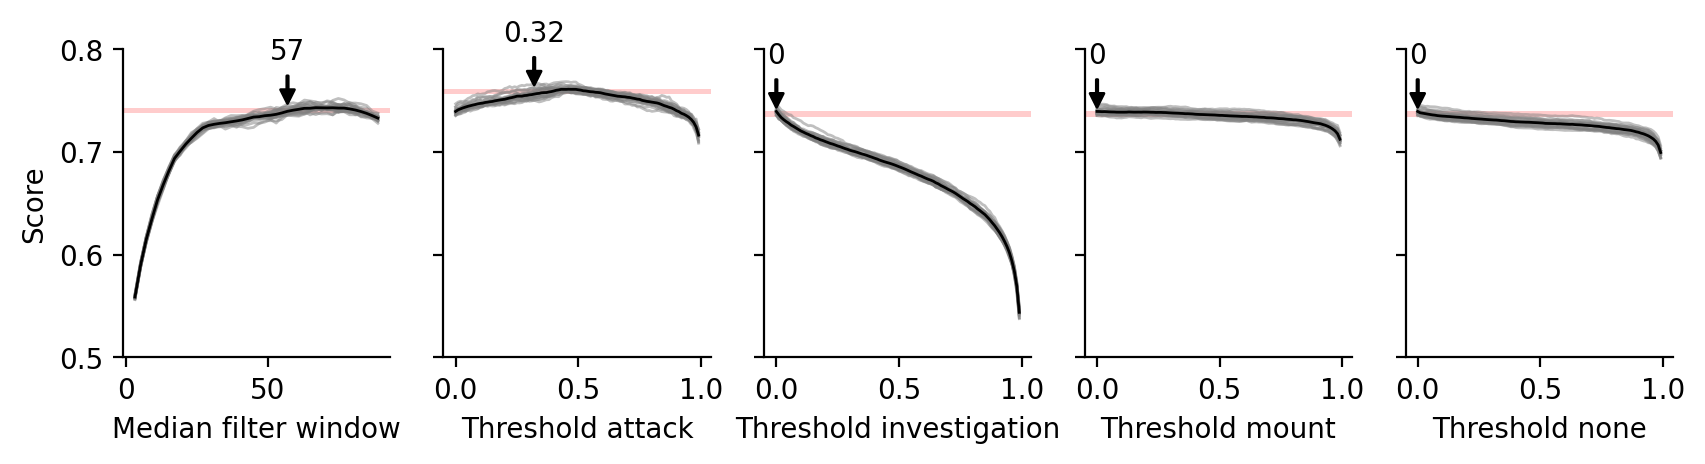

In [16]:
# instead, load results from smoothing_experiment-mice.py and thresholding_experiment-mice.py cluster runs

import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    1, len(dataset_train.categories) + 1, sharey=True, figsize=(10, 2)
)

smoothing_results = pd.read_csv("results_smoothing.csv", index_col=0)
evaluate_results(
    smoothing_results,
    parameter_names=["median_filter_window"],
    tolerance=0.005,
    plot_results=True,
    axes=axes[[0]],
)

for category_idx, category in enumerate(dataset_train.categories):
    thresholding_results_category = pd.read_csv(
        f"results_thresholding-{category}.csv", index_col=0
    )
    evaluate_results(
        thresholding_results_category,
        parameter_names=[f"threshold_{category}"],
        tolerance=0.005,
        plot_results=True,
        axes=axes[[category_idx + 1]],
    )

axes[0].set_yticks(np.arange(0.5, 0.9, 0.1))

for ax in axes[1:]:
    ax.set_ylabel("")

In [18]:
from helpers import optimal_smoothing_funcs, optimal_thresholds


k_fold_result = k_fold_predict(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    XGBClassifier(n_estimators=1000, random_state=1),
    k=5,
    random_state=1,
    sampling_func=subsample_train,
    log=set_logging_level("success"),
).smooth(optimal_smoothing_funcs, decision_thresholds=optimal_thresholds)

2025-02-18 18:25:11.625 [SUCCESS ] [fold: 0/5] finished sampling in 0.61 seconds
2025-02-18 18:27:28.396 [SUCCESS ] [fold: 0/5] finished fitting XGBClassifier in 136.74 seconds
2025-02-18 18:27:36.597 [SUCCESS ] [fold: 0/5] finished predicting on dataset in 8.20 seconds
2025-02-18 18:27:37.620 [SUCCESS ] [fold: 1/5] finished sampling in 0.98 seconds
2025-02-18 18:29:36.614 [SUCCESS ] [fold: 1/5] finished fitting XGBClassifier in 118.96 seconds
2025-02-18 18:29:41.707 [SUCCESS ] [fold: 1/5] finished predicting on dataset in 5.09 seconds
2025-02-18 18:29:42.717 [SUCCESS ] [fold: 2/5] finished sampling in 0.96 seconds
2025-02-18 18:31:33.622 [SUCCESS ] [fold: 2/5] finished fitting XGBClassifier in 110.87 seconds
2025-02-18 18:31:40.033 [SUCCESS ] [fold: 2/5] finished predicting on dataset in 6.41 seconds
2025-02-18 18:31:41.018 [SUCCESS ] [fold: 3/5] finished sampling in 0.94 seconds
2025-02-18 18:34:14.533 [SUCCESS ] [fold: 3/5] finished fitting XGBClassifier in 153.48 seconds
2025-02-18

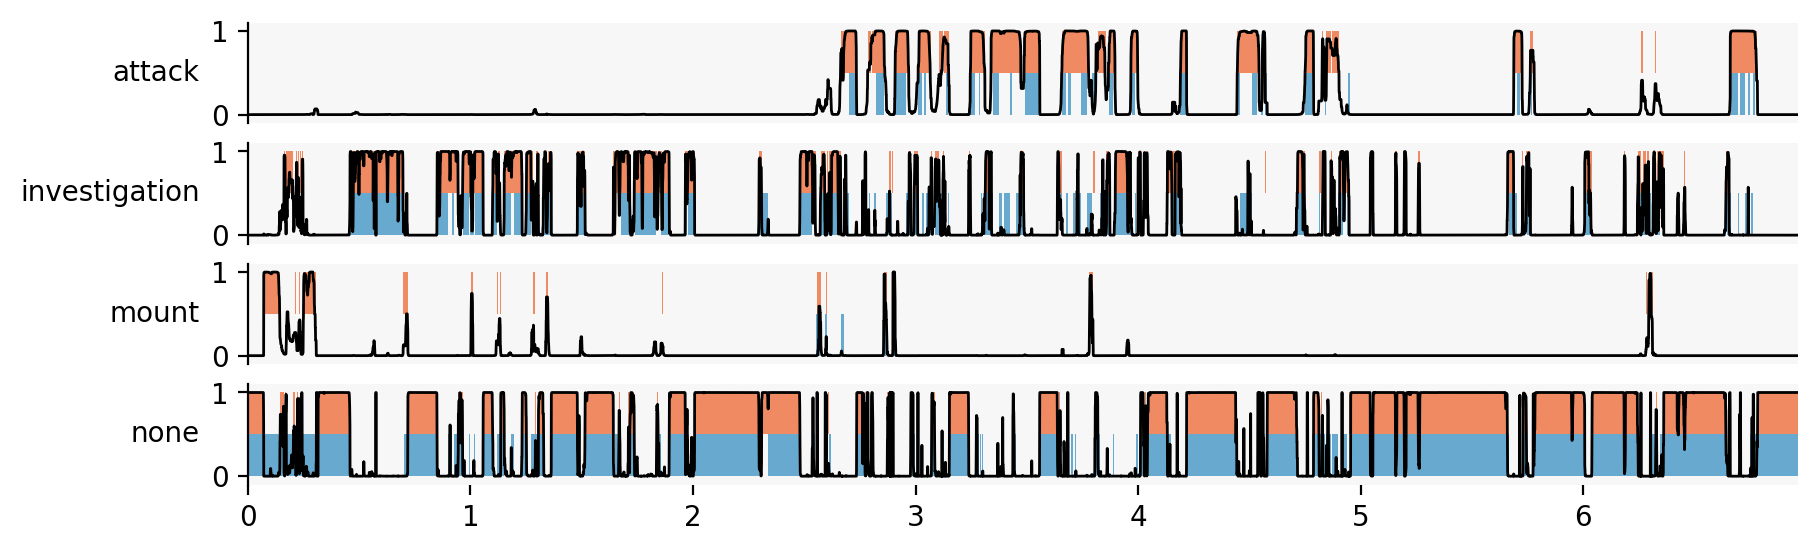

In [28]:
dyad_results = k_fold_result.classification_results[69].classification_results[
    ("resident", "intruder")
]

plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    interval=(-np.inf, np.inf),
    # y_proba=dyad_results.y_proba,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)